## Hyperparameter Tuning for the LP Solver

### Summary

                    param problem       res.fun   desired_fun success?  status
0   (1e-05, 1e-10, 1e-15)   AFIRO  4.647531e+02  4.647531e+02     True     0.0
1   (1e-05, 1e-10, 1e-15)     AGG  3.629123e+07  3.599177e+07    False     0.0
2   (1e-05, 1e-10, 1e-16)   AFIRO  4.647531e+02  4.647531e+02     True     0.0
3   (1e-05, 1e-10, 1e-16)     AGG  3.629123e+07  3.599177e+07    False     0.0
4   (1e-05, 1e-11, 1e-15)   AFIRO  4.647531e+02  4.647531e+02     True     0.0
5   (1e-05, 1e-11, 1e-15)     AGG  1.041062e+07  3.599177e+07    False     0.0
6   (1e-05, 1e-11, 1e-16)   AFIRO  4.647531e+02  4.647531e+02     True     0.0
7   (1e-05, 1e-11, 1e-16)     AGG  1.041062e+07  3.599177e+07    False     0.0
8   (1e-06, 1e-10, 1e-15)   AFIRO  4.647531e+02  4.647531e+02     True     0.0
9   (1e-06, 1e-10, 1e-15)     AGG  3.629123e+07  3.599177e+07    False     0.0
10  (1e-06, 1e-10, 1e-16)   AFIRO  4.647531e+02  4.647531e+02     True     0.0
11  (1e-06, 1e-10, 1e-16)     AGG  3.629123e+07  3.5

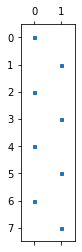

In [1]:
# import
from quantecon.optimize import linprog_simplex
#from quantecon.gridtools import cartesian

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from collections import namedtuple
from itertools import product
import glob
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')


def main(param_problem_pair):
    param = param_problem_pair[0]
    problem_name = param_problem_pair[1]
    problem = problem = np.load(problem_name)

    piv_options = PivOptions(param[0], param[1], param[2])

    problem = np.load(problem_name)
    c = - problem['c']
    A_eq = problem['A_eq']
    A_ub = problem['A_ub']
    b_eq = problem['b_eq']
    b_ub = problem['b_ub']
    desired_fun = problem['obj']
    res = linprog_simplex(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub,
                          piv_options=piv_options)
    problem_name = problem_name[len('./linprog_benchmark_files/'):-4]

    result_dict = {'param': str(param), 'problem': problem_name,
                   'res.fun': res.fun, 'desired_fun': -desired_fun,
                   'success?': np.isclose(res.fun, -desired_fun),
                   'status': res.status}
    return result_dict


if __name__ == '__main__':
    # path
    data_dir = './linprog_benchmark_files/'

    # full_problem_list
    problem_list = glob.glob(data_dir + '*.npz')
    problem_list.sort()
    remove_list = ['80BAU3B', 'BORE3D', 'CAPRI', 'CYCLE', 'CZPROB', 'D6CUBE',
                   'DFL001', 'ETAMACRO', 'FINNIS', 'FIT1D', 'FIT1P', 'FIT2D',
                   'FIT2P', 'GANGES', 'GFRD-PNC', 'GREENBEA', 'GREENBEB',
                   'GROW15', 'GROW22', 'GROW7', 'KB2', 'MAROS', 'MODSZK1',
                   'PEROLD', 'PILOT', 'PILOT-JA', 'PILOT-WE', 'PILOT4',
                   'PILOT87', 'PILOTNOV', 'RECIPE', 'SHELL', 'SIERRA',
                   'STAIR', 'STANDATA', 'STANDMPS', 'TUFF', 'VTP-BASE'
                   ]
    for name in remove_list:
        problem_list.remove(data_dir + name + '.npz')

    # Below, we work on a small problem set
    PivOptions = namedtuple(
        'PivOptions', ['fea_tol', 'tol_piv', 'tol_ratio_diff']
    )

    fea_tol_list = [1e-5, 1e-6]
    tol_piv_list = [1e-10, 1e-11]
    tol_ratio_diff_list = [1e-15, 1e-16]
    param_set = product(fea_tol_list, tol_piv_list, tol_ratio_diff_list)

    problem_list = ['./linprog_benchmark_files/AFIRO.npz',
                    './linprog_benchmark_files/AGG.npz']

    num_problem = len(problem_list)
    num_param =\
        len(fea_tol_list) * len(tol_piv_list) * len(tol_ratio_diff_list)
    num_row = num_problem * num_param
    column_list =\
        ['param', 'problem', 'res.fun', 'desired_fun', 'success?', 'status']
    num_column = len(column_list)
    df = pd.DataFrame(np.zeros((num_row, num_column)))
    df.columns = column_list
    row_index = 0

    param_problem_list = product(param_set, problem_list)

    # parallelization
    n_cores = cpu_count()
    p = Pool(n_cores)
    result_dicts = p.map(main, param_problem_list)

    # convertion to pandas dataframe
    for row_index, result_dict in enumerate(result_dicts):
        df['param'][row_index] = result_dict['param']
        df['problem'][row_index] = result_dict['problem']
        df['res.fun'][row_index] = result_dict['res.fun']
        df['desired_fun'][row_index] = result_dict['desired_fun']
        df['success?'][row_index] = result_dict['success?']
        df['status'][row_index] = result_dict['status']

    print(df)
    df.to_csv('results.csv')

    # visualization
    result_matrix = np.zeros((num_param, num_problem))

    result_column = df['success?']
    for i in range(num_param):
        result_matrix[i] = result_column[i:i+num_problem]

    plt.spy(result_matrix, markersize=3)
    plt.savefig('result_table.png')
    plt.show()

I left the memo below:

### An Example

In [43]:
from quantecon.optimize import linprog_simplex
#from quantecon.gridtools import cartesian

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from collections import namedtuple
from itertools import product
import glob

In [3]:
%%time
c = np.array([2, 4, 9, 11, 4, 3, 8, 7, 0, 15, 16, 18]) * (-1)
n, p = -1, 1
A_eq = [
    [n, n, p, 0, p, 0, 0, 0, 0, p, 0, 0],
    [p, 0, 0, p, 0, p, 0, 0, 0, 0, 0, 0],
    [0, 0, n, n, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, p, p, 0, 0, p, 0],
    [0, 0, 0, 0, n, n, n, 0, p, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, n, n, 0, 0, p],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, n, n, n]]
b_eq = [0, 19, -16, 33, 0, 0, -36]
c, A_eq, b_eq = map(np.asarray, [c, A_eq, b_eq])
desired_fun = -755
res = linprog_simplex(c, A_eq=A_eq, b_eq=b_eq)

print(np.isclose(res.fun, desired_fun))

True
CPU times: user 951 ms, sys: 21.6 ms, total: 972 ms
Wall time: 985 ms


### 

Although Quentin recommended that we use `quantecon.gridtools.cartesian`, `itertools.product` seems to work more intuitively to create a direct product of three lists.

In [4]:
PivOptions = namedtuple(
    'PivOptions', ['fea_tol', 'tol_piv', 'tol_ratio_diff']
)

In [5]:
fea_tol_list = [1e-5, 1e-6]
tol_piv_list = [1e-10, 1e-11]
tol_ratio_diff_list = [1e-15, 1e-16]
param_set = product(fea_tol_list, tol_piv_list, tol_ratio_diff_list)
list(param_set)

[(1e-05, 1e-10, 1e-15),
 (1e-05, 1e-10, 1e-16),
 (1e-05, 1e-11, 1e-15),
 (1e-05, 1e-11, 1e-16),
 (1e-06, 1e-10, 1e-15),
 (1e-06, 1e-10, 1e-16),
 (1e-06, 1e-11, 1e-15),
 (1e-06, 1e-11, 1e-16)]

In [6]:
%%time
PivOptions = namedtuple(
    'PivOptions', ['fea_tol', 'tol_piv', 'tol_ratio_diff']
)

fea_tol_list = [1e-5, 1e-6]
tol_piv_list = [1e-10, 1e-11]
tol_ratio_diff_list = [1e-15, 1e-16]
param_set = product(fea_tol_list, tol_piv_list, tol_ratio_diff_list)

for param in param_set:
    PivOptions.__new__.__defaults__ = param
    c = np.array([2, 4, 9, 11, 4, 3, 8, 7, 0, 15, 16, 18]) * (-1)
    A_eq = [
        [n, n, p, 0, p, 0, 0, 0, 0, p, 0, 0],
        [p, 0, 0, p, 0, p, 0, 0, 0, 0, 0, 0],
        [0, 0, n, n, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, p, p, 0, 0, p, 0],
        [0, 0, 0, 0, n, n, n, 0, p, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, n, n, 0, 0, p],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, n, n, n]]
    b_eq = [0, 19, -16, 33, 0, 0, -36]
    c, A_eq, b_eq = map(np.asarray, [c, A_eq, b_eq])
    desired_fun = -755
    res = linprog_simplex(c, A_eq=A_eq, b_eq=b_eq)
    
    print(param)
    print(np.isclose(res.fun, desired_fun))

(1e-05, 1e-10, 1e-15)
True
(1e-05, 1e-10, 1e-16)
True
(1e-05, 1e-11, 1e-15)
True
(1e-05, 1e-11, 1e-16)
True
(1e-06, 1e-10, 1e-15)
True
(1e-06, 1e-10, 1e-16)
True
(1e-06, 1e-11, 1e-15)
True
(1e-06, 1e-11, 1e-16)
True
CPU times: user 2.21 ms, sys: 1.01 ms, total: 3.23 ms
Wall time: 2.27 ms


### Solve Benchmark Problems

* We use [The NETLIB Linear Programming test set](http://www.cuter.rl.ac.uk/Problems/netlib.shtml), which is also used in 
[scypy](https://github.com/scipy/scipy/tree/master/benchmarks/benchmarks/linprog_benchmark_files) implementation of LP solver.

* NB: In scipy implementation, the problem is formulated as a minimization problem. Since our `linprog_simplex` is for a maximization, we should be careful when comparing the oprimal values.

In [7]:
data_dir = './linprog_benchmark_files/'

In [8]:
problem = np.load(data_dir + 'ADLITTLE.npz')

In [9]:
print(problem.files)

['c', 'obj', 'A_ub', 'A_eq', 'bounds', 'b_ub', 'b_eq']


In [22]:
PivOptions.__new__.__defaults__ = (1e-06, 1e-10, 1e-15)

In [38]:
%%time
problem = np.load(data_dir + 'ADLITTLE.npz')
c = - problem['c']
A_eq = problem['A_eq']
A_ub = problem['A_ub']
b_eq = problem['b_eq']
b_ub = problem['b_ub']
#c, A_eq, b_eq = map(np.asarray, [c, A_eq, b_eq])
desired_fun = problem['obj']
res = linprog_simplex(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, piv_options=PivOptions())

print(np.isclose(res.fun, -desired_fun))

True
CPU times: user 5.09 ms, sys: 1.59 ms, total: 6.67 ms
Wall time: 5.37 ms


In [41]:
%%time
problem = np.load(data_dir + 'AFIRO.npz')
c = - problem['c']
A_eq = problem['A_eq']
A_ub = problem['A_ub']
b_eq = problem['b_eq']
b_ub = problem['b_ub']
#c, A_eq, b_eq = map(np.asarray, [c, A_eq, b_eq])
desired_fun = problem['obj']
res = linprog_simplex(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, piv_options=PivOptions())

print(np.isclose(res.fun, -desired_fun))

True
CPU times: user 4.66 ms, sys: 1.6 ms, total: 6.26 ms
Wall time: 4.97 ms


* Create the list of test problems. 
* As Quentin did before, we omit some problems.
* The omitted problems are:
  - B or BR problems
  - QAP15, STOCFOR3 (too big to handle)

In [69]:
problem_list = glob.glob(data_dir + '*.npz')
problem_list.sort()
remove_list = ['80BAU3B', 'BORE3D', 'CAPRI', 'CYCLE', 'CZPROB', 'D6CUBE', 'DFL001', 'ETAMACRO', 'FINNIS',
               'FIT1D', 'FIT1P', 'FIT2D', 'FIT2P', 'GANGES', 'GFRD-PNC', 'GREENBEA', 'GREENBEB', 'GROW15', 'GROW22', 'GROW7',
               'KB2', 'MAROS', 'MODSZK1', 'PEROLD', 'PILOT', 'PILOT-JA', 'PILOT-WE', 'PILOT4', 'PILOT87', 'PILOTNOV', 'RECIPE',
               'SHELL', 'SIERRA', 'STAIR', 'STANDATA', 'STANDMPS', 'TUFF', 'VTP-BASE'
              ]
for name in remove_list:
    #print(name)
    problem_list.remove(data_dir + name + '.npz')
#problem_list

In [28]:
%%time
import warnings
warnings.filterwarnings('ignore')

PivOptions = namedtuple(
    'PivOptions', ['fea_tol', 'tol_piv', 'tol_ratio_diff']
)

fea_tol_list = [1e-5, 1e-6]
tol_piv_list = [1e-10, 1e-11]
tol_ratio_diff_list = [1e-15, 1e-16]
param_set = product(fea_tol_list, tol_piv_list, tol_ratio_diff_list)

# problem_list = ['./linprog_benchmark_files/AFIRO.npz', './linprog_benchmark_files/AGG.npz', './linprog_benchmark_files/E226.npz',
#                 './linprog_benchmark_files/FFFFF800.npz',
#                 './linprog_benchmark_files/ISRAEL.npz', './linprog_benchmark_files/LOTFI.npz',
#                 './linprog_benchmark_files/SHARE1B.npz', './linprog_benchmark_files/QAP8.npz'
#                ]
problem_list = ['./linprog_benchmark_files/AFIRO.npz', './linprog_benchmark_files/AGG.npz']

num_problem = len(problem_list)
num_param = len(fea_tol_list) * len(tol_piv_list) * len(tol_ratio_diff_list)
num_row = num_problem * num_param
column_list =  ['param', 'problem', 'res.fun', 'desired_fun', 'success?', 'status']
num_column = len(column_list)
df = pd.DataFrame(np.zeros((num_row, num_column)))
df.columns = column_list
row_index = 0

for param in param_set:
    PivOptions.__new__.__defaults__ = param
    
    for problem_name in problem_list:
        problem = np.load(problem_name)
        c = - problem['c']
        A_eq = problem['A_eq']
        A_ub = problem['A_ub']
        b_eq = problem['b_eq']
        b_ub = problem['b_ub']
        desired_fun = problem['obj']
        res = linprog_simplex(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, piv_options=PivOptions())
        
        df['param'][row_index] = str(param)
        problem_name = problem_name[len('./linprog_benchmark_files/'):-4]
        df['problem'][row_index] = problem_name
        df['res.fun'][row_index] = res.fun
        df['desired_fun'][row_index] = -desired_fun
        df['success?'][row_index] = np.isclose(res.fun, -desired_fun)
        df['status'][row_index] = res.status
        
        row_index += 1
        
df

CPU times: user 1.23 s, sys: 18.5 ms, total: 1.24 s
Wall time: 1.26 s


,param,problem,res.fun,desired_fun,success?,status
0,"(1e-05, 1e-10, 1e-15)",AFIRO,4.647531e+02,4.647531e+02,True,0.0
1,"(1e-05, 1e-10, 1e-15)",AGG,3.629123e+07,3.599177e+07,False,0.0
2,"(1e-05, 1e-10, 1e-16)",AFIRO,4.647531e+02,4.647531e+02,True,0.0
3,"(1e-05, 1e-10, 1e-16)",AGG,3.629123e+07,3.599177e+07,False,0.0
4,"(1e-05, 1e-11, 1e-15)",AFIRO,4.647531e+02,4.647531e+02,True,0.0
5,"(1e-05, 1e-11, 1e-15)",AGG,1.041062e+07,3.599177e+07,False,0.0
6,"(1e-05, 1e-11, 1e-16)",AFIRO,4.647531e+02,4.647531e+02,True,0.0
7,"(1e-05, 1e-11, 1e-16)",AGG,1.041062e+07,3.599177e+07,False,0.0
8,"(1e-06, 1e-10, 1e-15)",AFIRO,4.647531e+02,4.647531e+02,True,0.0
9,"(1e-06, 1e-10, 1e-15)",AGG,3.629123e+07,3.599177e+07,False,0.0


In [17]:
# iterator behavior
prod = product([0,1], [0,1])
print(len(list(prod)))
print(len(list(prod)))

4
0


In [41]:
result_matrix = np.zeros((num_param, num_problem))
result_matrix

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [42]:
result_column = df['success?']
for i in range(num_param):
    result_matrix[i] = result_column[i:i+num_problem]
result_matrix

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

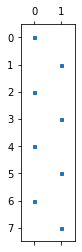

In [47]:
plt.spy(result_matrix, markersize=3)
plt.show()

### Parallelization

                    param problem       res.fun   desired_fun success?  status
0   (1e-05, 1e-10, 1e-15)   AFIRO  4.647531e+02  4.647531e+02     True     0.0
1   (1e-05, 1e-10, 1e-15)     AGG  3.629123e+07  3.599177e+07    False     0.0
2   (1e-05, 1e-10, 1e-16)   AFIRO  4.647531e+02  4.647531e+02     True     0.0
3   (1e-05, 1e-10, 1e-16)     AGG  3.629123e+07  3.599177e+07    False     0.0
4   (1e-05, 1e-11, 1e-15)   AFIRO  4.647531e+02  4.647531e+02     True     0.0
5   (1e-05, 1e-11, 1e-15)     AGG  1.041062e+07  3.599177e+07    False     0.0
6   (1e-05, 1e-11, 1e-16)   AFIRO  4.647531e+02  4.647531e+02     True     0.0
7   (1e-05, 1e-11, 1e-16)     AGG  1.041062e+07  3.599177e+07    False     0.0
8   (1e-06, 1e-10, 1e-15)   AFIRO  4.647531e+02  4.647531e+02     True     0.0
9   (1e-06, 1e-10, 1e-15)     AGG  3.629123e+07  3.599177e+07    False     0.0
10  (1e-06, 1e-10, 1e-16)   AFIRO  4.647531e+02  4.647531e+02     True     0.0
11  (1e-06, 1e-10, 1e-16)     AGG  3.629123e+07  3.5

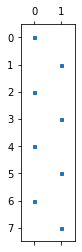

In [3]:
# import
from quantecon.optimize import linprog_simplex
#from quantecon.gridtools import cartesian

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from collections import namedtuple
from itertools import product
import glob
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')


def main(param_problem_pair):
    param = param_problem_pair[0]
    problem_name = param_problem_pair[1]
    problem = problem = np.load(problem_name)
    
    piv_options = PivOptions(param[0], param[1], param[2])

    problem = np.load(problem_name)
    c = - problem['c']
    A_eq = problem['A_eq']
    A_ub = problem['A_ub']
    b_eq = problem['b_eq']
    b_ub = problem['b_ub']
    desired_fun = problem['obj']
    res = linprog_simplex(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub,
                          piv_options=piv_options)
    problem_name = problem_name[len('./linprog_benchmark_files/'):-4]

    result_dict = {'param':str(param), 'problem':problem_name,
                   'res.fun':res.fun, 'desired_fun':-desired_fun,
                   'success?':np.isclose(res.fun, -desired_fun),
                   'status':res.status}
    return result_dict


if __name__ == '__main__':
    # path
    data_dir = './linprog_benchmark_files/'

    # full_problem_list
    problem_list = glob.glob(data_dir + '*.npz')
    problem_list.sort()
    remove_list = ['80BAU3B', 'BORE3D', 'CAPRI', 'CYCLE', 'CZPROB', 'D6CUBE',
                   'DFL001', 'ETAMACRO', 'FINNIS', 'FIT1D', 'FIT1P', 'FIT2D',
                   'FIT2P', 'GANGES', 'GFRD-PNC', 'GREENBEA', 'GREENBEB',
                   'GROW15', 'GROW22', 'GROW7', 'KB2', 'MAROS', 'MODSZK1',
                   'PEROLD', 'PILOT', 'PILOT-JA', 'PILOT-WE', 'PILOT4',
                   'PILOT87', 'PILOTNOV', 'RECIPE', 'SHELL', 'SIERRA',
                   'STAIR', 'STANDATA', 'STANDMPS', 'TUFF', 'VTP-BASE'
                  ]
    for name in remove_list:
        problem_list.remove(data_dir + name + '.npz')


    # Below, we work on a small problem set
    PivOptions = namedtuple(
        'PivOptions', ['fea_tol', 'tol_piv', 'tol_ratio_diff']
    )

    fea_tol_list = [1e-5, 1e-6]
    tol_piv_list = [1e-10, 1e-11]
    tol_ratio_diff_list = [1e-15, 1e-16]
    param_set = product(fea_tol_list, tol_piv_list, tol_ratio_diff_list)

    # problem_list = ['./linprog_benchmark_files/AFIRO.npz', './linprog_benchmark_files/AGG.npz', './linprog_benchmark_files/E226.npz',
    #                 './linprog_benchmark_files/FFFFF800.npz',
    #                 './linprog_benchmark_files/ISRAEL.npz', './linprog_benchmark_files/LOTFI.npz',
    #                 './linprog_benchmark_files/SHARE1B.npz', './linprog_benchmark_files/QAP8.npz'
    #                ]
    problem_list = ['./linprog_benchmark_files/AFIRO.npz',
                    './linprog_benchmark_files/AGG.npz']

    num_problem = len(problem_list)
    num_param =\
        len(fea_tol_list) * len(tol_piv_list) * len(tol_ratio_diff_list)
    num_row = num_problem * num_param
    column_list =\
        ['param', 'problem', 'res.fun', 'desired_fun', 'success?', 'status']
    num_column = len(column_list)
    df = pd.DataFrame(np.zeros((num_row, num_column)))
    df.columns = column_list
    row_index = 0

    param_problem_list = product(param_set, problem_list)

    # parallelization
    n_cores = cpu_count()
    p = Pool(n_cores)
    result_dicts = p.map(main, param_problem_list)

    # convertion to pandas dataframe
    for row_index, result_dict in enumerate(result_dicts):
        df['param'][row_index] = result_dict['param']
        df['problem'][row_index] = result_dict['problem']
        df['res.fun'][row_index] = result_dict['res.fun']
        df['desired_fun'][row_index] = result_dict['desired_fun']
        df['success?'][row_index] = result_dict['success?']
        df['status'][row_index] = result_dict['status']

    print(df)
    df.to_csv('results.csv')

    # visualization
    result_matrix = np.zeros((num_param, num_problem))

    result_column = df['success?']
    for i in range(num_param):
        result_matrix[i] = result_column[i:i+num_problem]

    plt.spy(result_matrix, markersize=3)
    plt.savefig('result_table.png')
    plt.show()